Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
# Import csv data
df = pd.read_csv('/car_data.csv')

In [3]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
197823,09/03/2016 11:41,6999,wagon,2006,auto,140,a4,100000,6,gasoline,audi,no,09/03/2016 00:00,0,81737,12/03/2016 21:16
305072,19/03/2016 20:57,299,wagon,1999,manual,110,focus,150000,10,petrol,ford,no,19/03/2016 00:00,0,44379,29/03/2016 03:17
75021,20/03/2016 21:55,5500,wagon,2005,auto,179,a6,150000,12,gasoline,audi,no,20/03/2016 00:00,0,31699,07/04/2016 07:16
69092,23/03/2016 00:55,2400,sedan,1998,manual,75,golf,100000,8,petrol,volkswagen,no,22/03/2016 00:00,0,59909,01/04/2016 09:15
289167,12/03/2016 22:57,2800,wagon,2001,manual,105,bora,150000,2,petrol,volkswagen,no,12/03/2016 00:00,0,22946,20/03/2016 12:17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# Drop irrelevant columns
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

Rename the colums to make the code look more consistent

In [6]:
# Rename columns
df = df.rename(columns={'Price': 'price', 'VehicleType': 'type', 'RegistrationYear': 'year', 'Gearbox' : 'gearbox' , 'Power': 'power', 'Model' : 'model', 'Mileage' : 'mileage', 'RegistrationMonth' : 'month', 'FuelType' : 'fuel_type', 'Brand' : 'make', 'NotRepaired' : 'not_repaird', 'NumberOfPictures' : 'pic_quantity' , 'PostalCode' : 'postal_code'})

In [7]:
# Check for missing values
df.isnull().sum() / df.isnull().count() * 100

price            0.000000
type            10.579368
year             0.000000
gearbox          5.596709
power            0.000000
model            5.560588
mileage          0.000000
month            0.000000
fuel_type        9.282697
make             0.000000
not_repaird     20.079070
pic_quantity     0.000000
postal_code      0.000000
dtype: float64

In [8]:
# Drop missing values
df = df.dropna()

In [9]:
# Check for outliers
df.describe()

,price,year,power,mileage,month,pic_quantity,postal_code
count,245814.000000,245814.000000,245814.000000,245814.000000,245814.000000,245814.0,245814.000000
mean,5125.346717,2002.918699,119.970884,127296.716216,6.179701,0.0,51463.186002
std,4717.948673,6.163765,139.387116,37078.820368,3.479519,0.0,25838.058847
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1499.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30966.000000
50%,3500.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,50769.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72379.000000
max,20000.000000,2018.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


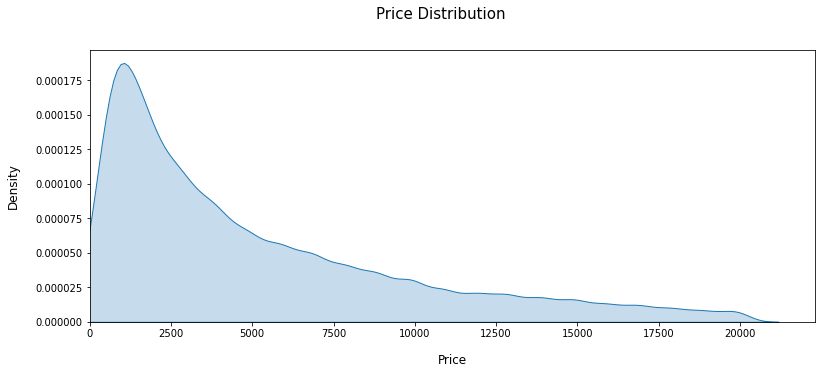

In [10]:
# Plot price distribution

fig = plt.figure(figsize=(13, 5))
fig.suptitle('Price Distribution', fontsize=15, y=1)
sns.kdeplot(df['price'], label='Price', fill=True)
plt.xlim(0, None)
plt.xlabel('Price', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.show()

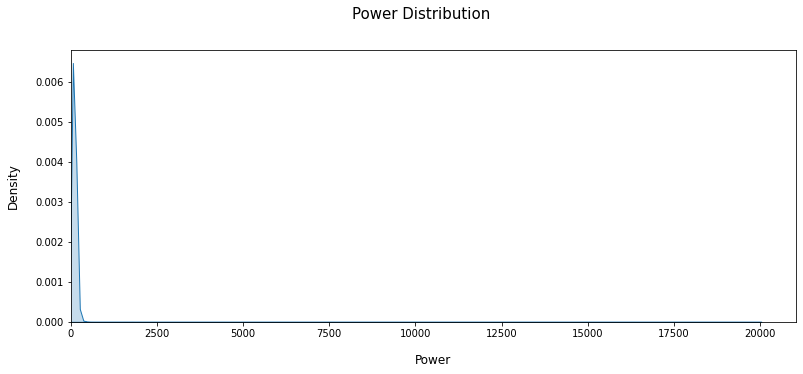

In [11]:
# Plot power distribution

fig = plt.figure(figsize=(13, 5))
fig.suptitle('Power Distribution', fontsize=15, y=1)
sns.kdeplot(df['power'], label='Price', fill=True)
plt.xlim(0, None)
plt.xlabel('Power', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.show()

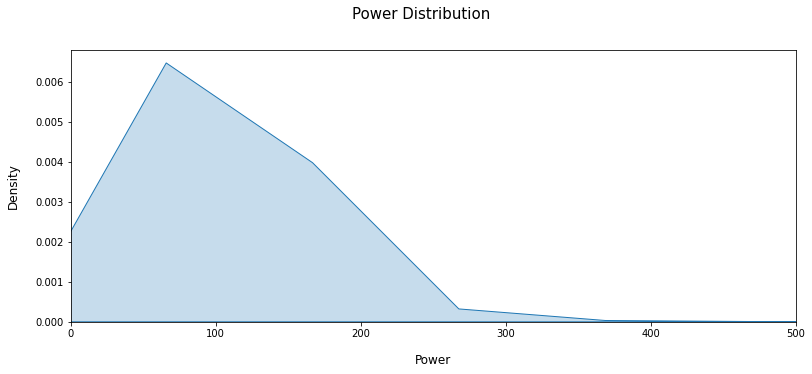

In [12]:
# Plot power distribution again with x-axis range [0-500] for readability

fig = plt.figure(figsize=(13, 5))
fig.suptitle('Power Distribution', fontsize=15, y=1)
sns.kdeplot(df['power'], label='Price', fill=True)
plt.xlim(0, 500)
plt.xlabel('Power', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.show()

In [13]:
# Drop outlier observations
df.drop(df[df['price'] >= 12500].index, inplace=True)
df.drop(df[df['power'] >= 200].index, inplace=True)
df.drop(df[df['power'] <= 50].index, inplace=True)

In [14]:
df.describe()

,price,year,power,mileage,month,pic_quantity,postal_code
count,192623.000000,192623.000000,192623.000000,192623.000000,192623.000000,192623.0,192623.000000
mean,3864.598885,2002.522134,110.932064,130317.173962,6.189121,0.0,51356.224963
std,3062.598466,5.588336,36.440917,34327.950934,3.461107,0.0,25808.101148
min,0.000000,1930.000000,51.000000,5000.000000,0.000000,0.0,1067.000000
25%,1399.000000,1999.000000,77.000000,125000.000000,3.000000,0.0,30952.000000
50%,2990.000000,2003.000000,107.000000,150000.000000,6.000000,0.0,50737.000000
75%,5800.000000,2006.000000,140.000000,150000.000000,9.000000,0.0,72160.000000
max,12499.000000,2018.000000,199.000000,150000.000000,12.000000,0.0,99998.000000


In [15]:
# Hot encoding of categorical features
data_ohe = pd.get_dummies(df, drop_first=True)

In [16]:
# Verify ohe completed
data_ohe

,price,year,power,mileage,month,pic_quantity,postal_code,type_convertible,type_coupe,type_other,...,make_saab,make_seat,make_skoda,make_smart,make_subaru,make_suzuki,make_toyota,make_volkswagen,make_volvo,not_repaird_yes
3,1500,2001,75,150000,6,0,91074,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,7,0,60437,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,650,1995,102,150000,10,0,33775,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,8,0,67112,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2000,2004,105,150000,12,0,96224,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354353,1999,1997,150,150000,12,0,4275,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354355,4400,2008,105,150000,7,0,45896,0,0,0,...,0,1,0,0,0,0,0,0,0,0
354359,7900,2010,140,150000,7,0,75223,0,0,0,...,0,0,0,0,0,0,0,1,0,0
354366,1199,2000,101,125000,3,0,26135,1,0,0,...,0,0,0,1,0,0,0,0,0,0


## Model training

In [17]:
# Function to calculate RMSE
def rmse(target,prediction):
    return mean_squared_error(target,prediction) ** 0.5

### Linear Regression

In [18]:
features_ohe = data_ohe.drop('price', axis=1)
target_ohe = data_ohe['price']

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe, target_ohe, test_size=0.25, random_state=12345)

In [19]:
%%time

lr_model = LinearRegression()
lr_model.fit(features_train_ohe,target_train_ohe)

CPU times: user 9.07 s, sys: 2.24 s, total: 11.3 s
Wall time: 11.3 s


LinearRegression()

In [20]:
%%time

predictions_valid = lr_model.predict(features_valid_ohe)
print('RMSE:', rmse(target_valid_ohe,predictions_valid))

RMSE: 1765.4272065863977
CPU times: user 58.9 ms, sys: 98.8 ms, total: 158 ms
Wall time: 189 ms


### Random Forest

In [21]:
%%time

rf_model = RandomForestRegressor(n_estimators=5, random_state=12345)
rf_model.fit(features_train_ohe,target_train_ohe) 
predictions_valid = rf_model.predict(features_valid_ohe)

print('RMSE:', rmse(target_valid_ohe,predictions_valid))

RMSE: 1270.2366917953298
CPU times: user 14 s, sys: 127 ms, total: 14.1 s
Wall time: 14.2 s


In [22]:
%%time

# Hyperparameter tuning using GridSearchCV

rf_model = RandomForestRegressor(random_state=12345)

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5]
}

# Create RMSE scorer using function created previously
scorer = make_scorer(rmse, greater_is_better=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=2, scoring=scorer)

# Fit GridSearchCV
grid_search.fit(features_train_ohe, target_train_ohe)

# Get the best parameters
best_params = grid_search.best_params_

print('Best parameters:', best_params)

Best parameters: {'max_depth': None, 'n_estimators': 100}
CPU times: user 13min 50s, sys: 2.02 s, total: 13min 52s
Wall time: 13min 52s


In [23]:
%%time

# Train the final model with the best parameters
final_rf_model = RandomForestRegressor(**best_params, random_state=12345)
final_rf_model.fit(features_train_ohe, target_train_ohe)

CPU times: user 4min 36s, sys: 711 ms, total: 4min 37s
Wall time: 4min 37s


RandomForestRegressor(random_state=12345)

In [24]:
%%time

# Make predictions
predictions_valid = final_rf_model.predict(features_valid_ohe)

print('RMSE:', rmse(target_valid_ohe,predictions_valid))

RMSE: 1170.4155255272028
CPU times: user 2.85 s, sys: 3.99 ms, total: 2.86 s
Wall time: 2.87 s


### CatBoost

In [25]:
features = df.drop('price', axis=1)
target = df['price']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

In [26]:
%%time

cat_features = [
    'type',
    'gearbox',
    'model',
    'fuel_type',
    'make',
    'not_repaird'
]

catboost_reg = CatBoostRegressor(iterations=150, random_seed=12345)

catboost_reg.fit(features_train, target_train, cat_features=cat_features, verbose=25)

predictions_valid = catboost_reg.predict(features_valid)

print('RMSE:', rmse(target_valid,predictions_valid))

Learning rate set to 0.420011
0:	learn: 2317.9741465	total: 154ms	remaining: 23s
25:	learn: 1287.2069364	total: 2.61s	remaining: 12.4s
50:	learn: 1239.9650775	total: 5.01s	remaining: 9.72s
75:	learn: 1214.3834656	total: 7.41s	remaining: 7.21s
100:	learn: 1201.3977060	total: 9.76s	remaining: 4.74s
125:	learn: 1186.7757056	total: 12.2s	remaining: 2.32s
149:	learn: 1175.2211558	total: 14.5s	remaining: 0us
RMSE: 1231.2454139873166
CPU times: user 14.8 s, sys: 83.9 ms, total: 14.9 s
Wall time: 15.1 s


In [27]:
%%time

# Tuning CatBoost model using GridSearchCV

catboost_reg = CatBoostRegressor()

# Define the parameter grid
grid = {
    'learning_rate': [0.3, 0.5],
    'depth': [2, 10],
    'iterations': [20, 150]
}

# Initialize GridSearchCV using same scorer defined previously
grid_search_result = GridSearchCV(catboost_reg, grid, cv=2, scoring=scorer)

# Fit the model
grid_search_result.fit(features_train, target_train, cat_features=cat_features, verbose=25)

# Get the best parameters
best_params = grid_search_result.best_params_

print('Best parameters:', best_params)

0:	learn: 2642.5738039	total: 26.6ms	remaining: 505ms
19:	learn: 1546.1779282	total: 401ms	remaining: 0us
0:	learn: 2644.5028503	total: 22.1ms	remaining: 419ms
19:	learn: 1550.9569412	total: 364ms	remaining: 0us
0:	learn: 2421.7919192	total: 21.6ms	remaining: 409ms
19:	learn: 1511.5572532	total: 358ms	remaining: 0us
0:	learn: 2419.5855757	total: 19.5ms	remaining: 371ms
19:	learn: 1509.8892341	total: 367ms	remaining: 0us
0:	learn: 2642.5738039	total: 21.8ms	remaining: 3.24s
25:	learn: 1511.8583265	total: 439ms	remaining: 2.09s
50:	learn: 1429.9672079	total: 872ms	remaining: 1.69s
75:	learn: 1390.6270609	total: 1.31s	remaining: 1.28s
100:	learn: 1366.6503072	total: 1.76s	remaining: 855ms
125:	learn: 1349.7533268	total: 2.17s	remaining: 414ms
149:	learn: 1337.6151635	total: 2.59s	remaining: 0us
0:	learn: 2644.5028503	total: 18.5ms	remaining: 2.76s
25:	learn: 1518.2490370	total: 476ms	remaining: 2.27s
50:	learn: 1454.9776744	total: 924ms	remaining: 1.79s
75:	learn: 1415.0076204	total: 1.38

In [28]:
%%time

# Train the final model with the best parameters
final_catboost_reg = CatBoostRegressor(**best_params)
final_catboost_reg.fit(features_train, target_train, cat_features=cat_features, verbose=25)

0:	learn: 2464.4800913	total: 207ms	remaining: 30.8s
25:	learn: 1215.0002917	total: 4.93s	remaining: 23.5s
50:	learn: 1150.2382753	total: 9.62s	remaining: 18.7s
75:	learn: 1116.4406254	total: 14.3s	remaining: 13.9s
100:	learn: 1093.9114062	total: 18.9s	remaining: 9.18s
125:	learn: 1071.1887011	total: 23.5s	remaining: 4.48s
149:	learn: 1052.2947882	total: 28.1s	remaining: 0us
CPU times: user 28.4 s, sys: 60 ms, total: 28.5 s
Wall time: 28.6 s


In [29]:
%%time

# Make predictions
predictions_valid = final_catboost_reg.predict(features_valid)

CPU times: user 95.5 ms, sys: 19 µs, total: 95.5 ms
Wall time: 102 ms


### XGBoost

In [30]:
%%time

# Initialize an XGBRegressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=12345)

# Fit the model
xg_reg.fit(features_train_ohe, target_train_ohe)

CPU times: user 4min 16s, sys: 438 ms, total: 4min 16s
Wall time: 4min 17s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
%%time

# Predict on the validation data
predictions_valid = xg_reg.predict(features_valid_ohe)

print('RMSE:', rmse(target_valid_ohe,predictions_valid))

RMSE: 1221.871817954829
CPU times: user 705 ms, sys: 0 ns, total: 705 ms
Wall time: 691 ms


### LightGBM

In [32]:
%%time

cat_features = [
    'type',
    'gearbox',
    'model',
    'fuel_type',
    'make',
    'not_repaird'
]

# Convert the categorical features in train and valid sets to 'category' dtype
for col in cat_features:
    features_train[col] = features_train[col].astype('category')
    features_valid[col] = features_valid[col].astype('category')

# Create LightGBM dataset for train and valid
lgb_train = lgb.Dataset(features_train, label=target_train, categorical_feature=cat_features)
lgb_valid = lgb.Dataset(features_valid, label=target_valid, categorical_feature=cat_features, reference=lgb_train)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'l2',
    'verbose': -1
}

# Train the model
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=150,
                valid_sets=lgb_valid
                )

<timed exec>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/s

[1]	valid_0's l2: 8.06356e+06
[2]	valid_0's l2: 7.00561e+06
[3]	valid_0's l2: 6.13541e+06
[4]	valid_0's l2: 5.41694e+06
[5]	valid_0's l2: 4.81945e+06
[6]	valid_0's l2: 4.32181e+06
[7]	valid_0's l2: 3.90973e+06
[8]	valid_0's l2: 3.56961e+06
[9]	valid_0's l2: 3.28841e+06
[10]	valid_0's l2: 3.0432e+06
[11]	valid_0's l2: 2.83265e+06
[12]	valid_0's l2: 2.65575e+06
[13]	valid_0's l2: 2.50372e+06
[14]	valid_0's l2: 2.37966e+06
[15]	valid_0's l2: 2.27433e+06
[16]	valid_0's l2: 2.18107e+06
[17]	valid_0's l2: 2.10152e+06
[18]	valid_0's l2: 2.03321e+06
[19]	valid_0's l2: 1.97413e+06
[20]	valid_0's l2: 1.92311e+06
[21]	valid_0's l2: 1.8795e+06
[22]	valid_0's l2: 1.83874e+06
[23]	valid_0's l2: 1.80655e+06
[24]	valid_0's l2: 1.77703e+06
[25]	valid_0's l2: 1.75036e+06
[26]	valid_0's l2: 1.72687e+06
[27]	valid_0's l2: 1.70619e+06
[28]	valid_0's l2: 1.6866e+06
[29]	valid_0's l2: 1.67004e+06
[30]	valid_0's l2: 1.65369e+06
[31]	valid_0's l2: 1.64043e+06
[32]	valid_0's l2: 1.6277e+06
[33]	valid_0's l2: 1.

In [33]:
%%time

# Predict on the validation set
predictions_valid = gbm.predict(features_valid, num_iteration=gbm.best_iteration)

print('RMSE:', rmse(target_valid,predictions_valid))

RMSE: 1197.5632147842266
CPU times: user 830 ms, sys: 11.7 ms, total: 841 ms
Wall time: 818 ms


## Model analysis

### Summary:
#### Regular Models:
- Linear Regression RMSE is 1765, trains in ~11 seconds, and predicts values in ~180 ms
- Random Forest Regressor RMSE is 1270 and trains in ~15 seconds
- Tuned Random Forest RMSE is 1170, trains in 4 minutes 40 seconds, and predicts values in 2.9 seconds. Tuning took ~14 minutes.

#### Gradient Boost Models:
- XGBoost RMSE is 1221, trains in 4 minutes 19 seconds, and predicts values in ~700 ms.
- CatBoost RMSE is 1231 and trains in ~15 seconds.
- Tuned CatBoost RMSE is 1192, trains in ~29 seconds, and predicts values in ~100 ms. Tuning took 2 minutes.
- LightGBM RMSE is 1197, trains in ~7 seconds, and predicts values in ~800 ms.


### Conclusions
- Tuned random forest regressor achieved the lowest RMSE of 1170 however tuning the random forest hyperparameters took 7x tuning CatBoost model. Tuned CatBoost model has RMSE of 1192, which is very similar to RMSE of LightGBM. LightGBM trains the fastest and has RMSE of 1197. XGBoost is the slowest of the gradient boost models taking 4+ minutes to train and achieving RMSE of 1221. 
- Trained CatBoost predicts values 7-8x faster than XGBoost, LightGBM, and even linear regression.
- Recommendation is to use CatBoost model for price predictions since it has RMSE 98% as good as tuned random forest model, trains in 1/9th of the time, and most importantly can predict values 7-8x faster than other gradient boost models which is important when there is a large number of users.